In [1]:
# Check GPU type
!nvidia-smi

Mon May 12 14:09:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8              2W /  115W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install ultralytics
!pip -q install  ultralytics


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing
import numpy as np
from PIL import Image

In [4]:
# INPUT_DIRS
INPUT_DATA_DIR = Path('.')

In [5]:
os.listdir(INPUT_DATA_DIR)

['.ipynb_checkpoints',
 'Averaged_Yolo11n_50epo_Yolo8.csv',
 'Averaged_Yolo11n_Yolo11m.csv',
 'Averaged_Yolo11n_Yolo11m_weighted.csv',
 'best_yolo11l.csv',
 'best_yolo11l_V1.csv',
 'BEST_YOLO11N.csv',
 'BIGDATA.csv',
 'BIGDATA_n.csv',
 'Cocoa_Disease_Starter_Notebook.ipynb',
 'data.yaml',
 'dataset',
 'dataset.zip',
 'dataset_tt',
 'dataset_tt.zip',
 'ensemble_best_last_wbf.csv',
 'ENSEMBLE_L_N.csv',
 'filtered_predictions_alternate.csv',
 'filtered_predictions_leave3.csv',
 'filter_BIG_DATA_E4.csv',
 'fused_detections.csv',
 'fused_detections_beuf.csv',
 'fused_detections_l_prim.csv',
 'FUUSION.csv',
 'Param_06_640_0_1.csv',
 'Param_06_800_0_001.csv',
 'Param_06_800_0_1.csv',
 'Param_06_800_0_25.csv',
 'PostNMS_Yolo11.csv',
 'PostNMS_Yolo11n.csv',
 'PostNMS_Yolo11n_IOU05_CONF025.csv',
 'postprocessed_results.csv',
 'PostProcess_Yolo11.csv',
 'POSTYolo11n_800_CONF01_IOU055.csv',
 'POSTYolo11n_832_CONF01_IOU05.csv',
 'POSTYolo11n_832_CONF01_IOU055.csv',
 'runs',
 'SampleSubmission.csv',

In [6]:
## Drop the Folder if it already exists
DATASETS_DIR = Path('dataset')
DATASETS_DIR

WindowsPath('dataset')

In [7]:
# Image & labels directory
TRAIN_IMAGES_DIR = DATASETS_DIR / 'images' / 'train'
TRAIN_LABELS_DIR = DATASETS_DIR / 'labels'/ 'train'
TEST_IMAGES_DIR = DATASETS_DIR / 'images' / 'test'
VAL_IMAGES_DIR = DATASETS_DIR / 'images' /'val'
VAL_LABELS_DIR = DATASETS_DIR / 'labels' /'val'

In [57]:
# Check if DATASETS_DIR exists, if it does delete it and recreate it
for DIR in [TRAIN_IMAGES_DIR, VAL_IMAGES_DIR, TEST_IMAGES_DIR, VAL_LABELS_DIR, DATASETS_DIR]:
  if DIR.exists():
    shutil.rmtree(DIR)
  DIR.mkdir(parents=True, exist_ok = True)

In [58]:
# Unpack the 'dataset.zip'
shutil.unpack_archive(INPUT_DATA_DIR / 'dataset.zip', DATASETS_DIR)

In [59]:
def count_files(directory):
    total_files = 0
    for root, _, files in os.walk(directory):
        total_files += len(files)
    return total_files

In [60]:
## Count the number files in TRAIN_IMAGES_DIR
num_train_images = count_files(TRAIN_IMAGES_DIR)
print(f"There are {num_train_images} in {TRAIN_IMAGES_DIR}")

There are 5529 in dataset\images\train


In [61]:
## Count the number of files in TRAIN_LABELS_DIR
num_train_labels = count_files(TRAIN_LABELS_DIR)
print(f"There are {num_train_labels} in {TRAIN_LABELS_DIR}")

There are 5529 in dataset\labels\train


In [62]:
## Get the set of all the stems of the images in TRAIN_IMAGES_DIR
train_images_stems = set([str(Path(name).stem) for name in os.listdir(TRAIN_IMAGES_DIR)])
len(train_images_stems)

5529

In [63]:
## Get the set of all the stems of the labes in TRAIN_LABELS_DIR
train_labels_stems = set([str(Path(name).stem) for name in os.listdir(TRAIN_LABELS_DIR)])
len(train_labels_stems)

5529

In [64]:
# Check that the two sets are identitical
train_images_stems == train_labels_stems

True

In [65]:
TRAIN_IMAGES_DIR.absolute()

WindowsPath('C:/Users/azizk/Desktop/ML_Consulting/Cacao/dataset/images/train')

In [66]:
# Load train and test files
train = pd.read_csv(INPUT_DATA_DIR / 'Train.csv')
test = pd.read_csv(INPUT_DATA_DIR / 'Test.csv')
ss = pd.read_csv(INPUT_DATA_DIR / 'SampleSubmission.csv')

In [67]:
## Sample submission file
ss.head()

Image_ID    class  confidence  ymin  xmin  ymax  xmax
0  ID_Genxyu.jpg  healthy         0.5   100   100   100   100
1  ID_svY6TG.jpg  healthy         0.5   100   100   100   100
2  ID_d0gpda.jpg  healthy         0.5   100   100   100   100
3  ID_frWmBT.jpg  healthy         0.5   100   100   100   100
4  ID_TaRW6o.jpg  healthy         0.5   100   100   100   100

In [68]:
train.head()

Image_ID    class  confidence   ymin   xmin   ymax   xmax  class_id  \
0  ID_nBgcAR.jpg  healthy         1.0   75.0   15.0  162.0  195.0         2   
1  ID_nBgcAR.jpg  healthy         1.0   58.0    1.0  133.0  171.0         2   
2  ID_nBgcAR.jpg  healthy         1.0   42.0   29.0  377.0  349.0         2   
3  ID_Kw2v8A.jpg  healthy         1.0  112.0  124.0  404.0  341.0         2   
4  ID_Kw2v8A.jpg  healthy         1.0  148.0  259.0  413.0  412.0         2   

                            ImagePath  
0  dataset/images/train/ID_nBgcAR.jpg  
1  dataset/images/train/ID_nBgcAR.jpg  
2  dataset/images/train/ID_nBgcAR.jpg  
3  dataset/images/train/ID_Kw2v8A.jpg  
4  dataset/images/train/ID_Kw2v8A.jpg

In [69]:
train['class'].unique()

array(['healthy', 'anthracnose', 'cssvd'], dtype=object)

In [70]:
train['class_id'].unique()

array([2, 0, 1], dtype=int64)

In [71]:
train[['class', 'class_id']].value_counts()

class        class_id
healthy      2           4279
cssvd        1           3223
anthracnose  0           2271
cssvd        0             18
healthy      1              1
Name: count, dtype: int64

In [72]:
class_map = {cls: i for i, cls in enumerate(sorted(train['class'].unique().tolist()))}
class_map

{'anthracnose': 0, 'cssvd': 1, 'healthy': 2}

In [73]:
# Strip any spacing from the class item and make sure that it is a str
train['class'] = train['class'].str.strip()

# Map {'healthy': 2, 'cssvd': 1, anthracnose: 0}
train['class_id'] = train['class'].map(class_map)

In [74]:
train[['class', 'class_id']].value_counts()

class        class_id
healthy      2           4280
cssvd        1           3241
anthracnose  0           2271
Name: count, dtype: int64

In [75]:
# Number of unique images path
train['ImagePath'].nunique()

5529

In [76]:
# Split the train dataset into train_df & val_df
train_names, val_names = train_test_split(train['Image_ID'].unique(), test_size=0.15, random_state=42)

train_df = train[train['Image_ID'].isin(train_names)]
val_df = train[train['Image_ID'].isin(val_names)]

In [77]:
train_df.head()

Image_ID    class  confidence   ymin   xmin   ymax   xmax  class_id  \
0  ID_nBgcAR.jpg  healthy         1.0   75.0   15.0  162.0  195.0         2   
1  ID_nBgcAR.jpg  healthy         1.0   58.0    1.0  133.0  171.0         2   
2  ID_nBgcAR.jpg  healthy         1.0   42.0   29.0  377.0  349.0         2   
3  ID_Kw2v8A.jpg  healthy         1.0  112.0  124.0  404.0  341.0         2   
4  ID_Kw2v8A.jpg  healthy         1.0  148.0  259.0  413.0  412.0         2   

                            ImagePath  
0  dataset/images/train/ID_nBgcAR.jpg  
1  dataset/images/train/ID_nBgcAR.jpg  
2  dataset/images/train/ID_nBgcAR.jpg  
3  dataset/images/train/ID_Kw2v8A.jpg  
4  dataset/images/train/ID_Kw2v8A.jpg

In [78]:
train_df.shape, val_df.shape, test.shape

((8236, 9), (1556, 9), (1626, 9))

In [79]:
ss.head()

Image_ID    class  confidence  ymin  xmin  ymax  xmax
0  ID_Genxyu.jpg  healthy         0.5   100   100   100   100
1  ID_svY6TG.jpg  healthy         0.5   100   100   100   100
2  ID_d0gpda.jpg  healthy         0.5   100   100   100   100
3  ID_frWmBT.jpg  healthy         0.5   100   100   100   100
4  ID_TaRW6o.jpg  healthy         0.5   100   100   100   100

In [80]:
# Preview target distribution, seems there a class imbalance that needs to be handled
train['class'].value_counts().plot(kind='bar')
plt.title('Train-Val Class Distribution')
plt.show();

<Figure size 640x480 with 1 Axes>

In [81]:
train_df['class'].value_counts().plot(kind='bar')
plt.title('Train - Class Distribution')
plt.show();

<Figure size 640x480 with 1 Axes>

In [82]:
val_df['class'].value_counts().plot(kind='bar')
plt.title('Val - Class Distribution')
plt.show();

<Figure size 640x480 with 1 Axes>

In [83]:
# Create a data.yaml file required by yolo
class_names = sorted(train['class'].unique().tolist())
num_classes = len(class_names)

data_yaml = {
    "path" : str(DATASETS_DIR.absolute()),
    'train': str(TRAIN_IMAGES_DIR.absolute()),
    'val': str(VAL_IMAGES_DIR.absolute()),
    'test': str(TEST_IMAGES_DIR.absolute()),
    'nc': num_classes,
    'names': class_names
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'path': 'C:\\Users\\azizk\\Desktop\\ML_Consulting\\Cacao\\dataset',
 'train': 'C:\\Users\\azizk\\Desktop\\ML_Consulting\\Cacao\\dataset\\images\\train',
 'val': 'C:\\Users\\azizk\\Desktop\\ML_Consulting\\Cacao\\dataset\\images\\val',
 'test': 'C:\\Users\\azizk\\Desktop\\ML_Consulting\\Cacao\\dataset\\images\\test',
 'nc': 3,
 'names': ['anthracnose', 'cssvd', 'healthy']}

In [84]:
len(val_names), len(set(val_names))

(830, 830)

In [85]:
val_image_names = [str(Path(name).stem) for name in val_df['Image_ID'].unique()]

In [86]:
len(val_image_names)

830

In [87]:
# list of images in TRAIN_IMAGES_DIR
images_in_train_dir = os.listdir(TRAIN_IMAGES_DIR)
len(images_in_train_dir), len(train_names)

(5529, 4699)

In [88]:
train_image_names = [str(Path(name).stem) for name in train['ImagePath'].unique()]

In [89]:
len(train_image_names)

5529

In [90]:
# Check that VAL_IMAGES_DIR & VAL_LABELS_DIR exist if not create them
for DIR in [VAL_IMAGES_DIR, VAL_LABELS_DIR]:
  if not DIR.exists():
    DIR.mkdir(parents=True, exist_ok = True)

In [91]:
# Copy images in val_names to dataset/val and do the same with the labels
for image_name in tqdm(val_names):
    shutil.move(TRAIN_IMAGES_DIR / image_name, VAL_IMAGES_DIR / image_name)
    img_ext = image_name.split('.')[-1]
    label_name = image_name.replace(f'.{img_ext}', '.txt')
    shutil.move(TRAIN_LABELS_DIR / label_name, VAL_LABELS_DIR / label_name)

  0%|          | 0/830 [00:00<?, ?it/s]

In [92]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = np.array(Image.open(str(image_path)))


    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=8, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:5]:
    image_path = IMAGE_DIR / image_name
    img_ext = image_name.split('.')[-1]
    label_path = LABEL_DIR / (image_name.replace(f'.{img_ext}', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


Plotting ID_a0M4cn.jpg with 2 bounding boxes.


<Figure size 1000x1000 with 1 Axes>

Plotting ID_A1OsZt.jpeg with 1 bounding boxes.


<Figure size 1000x1000 with 1 Axes>

Plotting ID_a2zxFb.jpg with 1 bounding boxes.


<Figure size 1000x1000 with 1 Axes>

Plotting ID_a34fvU.jpg with 6 bounding boxes.


<Figure size 1000x1000 with 1 Axes>

Plotting ID_A397lM.jpg with 1 bounding boxes.


<Figure size 1000x1000 with 1 Axes>

In [25]:
from ultralytics import YOLO

model = YOLO('runs/detect/train2/weights/last.pt')  # load the last trained model


model.train(
    data='data.yaml',
    epochs=70,
    imgsz=640,
    batch=16,
    device=0,
    patience=15,
    augment=True,
    multi_scale=True,
    optimizer='AdamW',
    lr0=0.005,
    momentum=0.937,
    weight_decay=0.0005,
    cos_lr=True,
    warmup_epochs=1,
    translate=0.1,
    scale=0.5,
    fliplr=0.5,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    mosaic=1.0,
    val=True,
    save=True,
    save_period=1,
)


New https://pypi.org/project/ultralytics/8.3.130 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
engine\trainer: task=detect, mode=train, model=runs/detect/train2/weights/last.pt, data=data.yaml, epochs=70, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=0, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fals

train: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\train.cache... 4699 images, 0 backgrounds, 0 

train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AJD939.jpg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AMshRT.jpeg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AOGygM.jpeg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AbHMqL.jpg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AhmyiY.jpeg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AhwlUp.jpeg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AueB13.jpg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AzJAHH.jpg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\da

val: Fast image access  (ping: 0.30.0 ms, read: 142.075.8 MB/s, size: 3182.2 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor

Plotting labels to runs\detect\train11\labels.jpg... 
optimizer: AdamW(lr=0.005, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train11
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      6.08G      1.335      1.488       1.61         56        416: 100%|██████████| 294/294 [05:47<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:34


                   all        830       1556      0.454      0.339      0.308       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      5.25G      1.406      1.598      1.682         53        352: 100%|██████████| 294/294 [05:06<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:34


                   all        830       1556      0.522      0.501      0.493      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      6.01G       1.38      1.581      1.648         47        736: 100%|██████████| 294/294 [05:11<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:33


                   all        830       1556      0.517      0.459       0.47      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      5.21G      1.348      1.524      1.632         49        672: 100%|██████████| 294/294 [05:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:34


                   all        830       1556      0.629      0.515      0.562      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      5.21G      1.318      1.489      1.612         45        576: 100%|██████████| 294/294 [05:07<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:36


                   all        830       1556      0.639       0.52      0.572      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      5.48G      1.304       1.45      1.598         38        448: 100%|██████████| 294/294 [05:10<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:33


                   all        830       1556       0.61      0.466      0.505       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      5.81G      1.274      1.413      1.585         36        416: 100%|██████████| 294/294 [04:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:27

                   all        830       1556      0.722      0.566      0.634      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      5.73G      1.275      1.388      1.583         36        352: 100%|██████████| 294/294 [04:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09

                   all        830       1556      0.668      0.551      0.596      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      5.76G      1.277      1.375      1.573         42        800: 100%|██████████| 294/294 [10:49<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:24

                   all        830       1556      0.718      0.587      0.658      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      6.08G      1.242      1.328      1.561         46        864: 100%|██████████| 294/294 [04:58<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:20

                   all        830       1556      0.691      0.589      0.661      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      5.34G      1.237      1.328      1.553         40        864: 100%|██████████| 294/294 [04:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:08

                   all        830       1556       0.68      0.606      0.647      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      5.29G      1.264      1.339      1.562         65        576:  14%|█▍        | 41/294 [00:11<01:13,  3


KeyboardInterrupt: 

In [8]:
from ultralytics import YOLO

# Load the training session folder, not just weights
model = YOLO('runs/detect/train11/weights/last.pt')

model.train(resume=True)


Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
engine\trainer: task=detect, mode=train, model=runs\detect\train11\weights\last.pt, data=data.yaml, epochs=70, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=0, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=runs\detect\train11\weights\last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

train: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\train.cache... 4699 images, 0 backgrounds, 0 

train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AJD939.jpg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AMshRT.jpeg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AOGygM.jpeg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AbHMqL.jpg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AhmyiY.jpeg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AhwlUp.jpeg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AueB13.jpg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\train\ID_AzJAHH.jpg: corrupt JPEG restored and saved
train: C:\Users\azizk\Desktop\ML_Consulting\Cacao\da

val: Fast image access  (ping: 0.20.0 ms, read: 321.6161.2 MB/s, size: 3182.2 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor

Plotting labels to runs\detect\train11\labels.jpg... 
optimizer: AdamW(lr=0.005, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Resuming training runs\detect\train11\weights\last.pt from epoch 13 to 70 total epochs
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train11
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      6.36G      1.177      1.241      1.494         56        416: 100%|██████████| 294/294 [05:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:35


                   all        830       1556      0.706       0.58      0.632      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      5.01G      1.221      1.278      1.532         53        352: 100%|██████████| 294/294 [05:05<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:34

                   all        830       1556      0.649      0.582      0.626      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      6.05G      1.211      1.288      1.521         47        736: 100%|██████████| 294/294 [05:13<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 6/26 [00:22<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [02:58


                   all        830       1556      0.712      0.533      0.605      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      4.95G      1.204      1.259      1.519         49        672: 100%|██████████| 294/294 [05:04<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:34


                   all        830       1556      0.724      0.618      0.682      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      4.95G      1.193      1.241      1.511         45        576: 100%|██████████| 294/294 [05:06<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:33


                   all        830       1556      0.733      0.612      0.693      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      5.56G      1.193       1.24      1.508         38        448: 100%|██████████| 294/294 [05:04<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:33


                   all        830       1556      0.743      0.601      0.672       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      5.57G      1.172       1.21      1.496         36        416: 100%|██████████| 294/294 [05:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:08

                   all        830       1556      0.795      0.587      0.695      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      5.63G      1.181      1.199      1.507         36        352: 100%|██████████| 294/294 [01:24<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09

                   all        830       1556      0.762       0.61      0.709      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      5.67G      1.176      1.205      1.496         42        800: 100%|██████████| 294/294 [04:26<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.746      0.607      0.689       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70       5.8G      1.154      1.172      1.491         46        864: 100%|██████████| 294/294 [05:29<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:36

                   all        830       1556       0.74      0.609      0.678      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      5.11G      1.143      1.158      1.479         40        864: 100%|██████████| 294/294 [05:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:25

                   all        830       1556      0.721      0.621      0.691      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      5.03G      1.162       1.17      1.489         31        576: 100%|██████████| 294/294 [04:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:32

                   all        830       1556      0.746      0.618      0.702      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      5.72G      1.149      1.169      1.476         51        672: 100%|██████████| 294/294 [05:01<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:32

                   all        830       1556      0.716      0.641      0.709      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      4.93G      1.161      1.165      1.483         36        864: 100%|██████████| 294/294 [04:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:32


                   all        830       1556      0.731      0.614      0.692      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70       5.5G      1.142      1.139       1.47         41        704: 100%|██████████| 294/294 [04:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:33

                   all        830       1556      0.765      0.615      0.714      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      6.71G      1.136      1.139      1.462         45        608: 100%|██████████| 294/294 [05:19<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:34

                   all        830       1556      0.689      0.639        0.7      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      5.36G      1.136      1.128      1.474         46        544: 100%|██████████| 294/294 [05:03<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:32

                   all        830       1556      0.766      0.625      0.716      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      5.09G      1.126      1.104      1.453         39        352: 100%|██████████| 294/294 [04:47<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:22

                   all        830       1556       0.73      0.616      0.711       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      6.24G      1.122      1.105      1.455         44        640: 100%|██████████| 294/294 [05:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:27

                   all        830       1556      0.783      0.636      0.732      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      6.05G      1.121      1.093      1.457         36        800: 100%|██████████| 294/294 [06:10<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:34

                   all        830       1556      0.759      0.628      0.719      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      5.67G      1.117      1.087      1.447         58        384: 100%|██████████| 294/294 [06:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:40

                   all        830       1556       0.77       0.63      0.725       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      5.26G       1.11      1.075      1.459         43        736: 100%|██████████| 294/294 [05:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:36


                   all        830       1556      0.778      0.627      0.729       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      5.03G      1.097      1.069      1.453         34        640: 100%|██████████| 294/294 [03:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.763      0.646       0.72      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      5.03G      1.105      1.055      1.435         60        416: 100%|██████████| 294/294 [04:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.742      0.653      0.734       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      5.66G      1.105      1.063      1.443         48        640: 100%|██████████| 294/294 [05:01<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.765      0.646      0.729      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      5.82G      1.097      1.033      1.426         62        576: 100%|██████████| 294/294 [04:49<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.746      0.644      0.727       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      5.65G      1.084      1.039      1.437         55        608: 100%|██████████| 294/294 [05:04<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.738      0.668      0.733      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      5.34G      1.086      1.021      1.423         37        896: 100%|██████████| 294/294 [04:52<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.764      0.667      0.738      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      6.79G      1.076      1.027      1.413         36        480: 100%|██████████| 294/294 [03:16<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:18

                   all        830       1556      0.752       0.66      0.742      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      5.17G      1.082       1.01      1.439         56        448: 100%|██████████| 294/294 [05:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.751      0.646      0.729      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70       5.1G      1.067      1.004      1.434         43        672: 100%|██████████| 294/294 [05:28<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:38

                   all        830       1556      0.752      0.651      0.728      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      4.91G      1.058      1.009      1.412         50        480: 100%|██████████| 294/294 [03:24<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:42

                   all        830       1556      0.781      0.626      0.732        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      4.96G      1.066     0.9916      1.412         47        480: 100%|██████████| 294/294 [04:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:33

                   all        830       1556      0.784      0.635      0.739      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      5.61G      1.056     0.9862      1.394         39        480: 100%|██████████| 294/294 [06:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:34

                   all        830       1556      0.747      0.677       0.74      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      5.55G      1.048     0.9844      1.405         40        544: 100%|██████████| 294/294 [13:05<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:39

                   all        830       1556      0.764       0.65      0.739      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      5.55G       1.06     0.9737      1.407         38        928: 100%|██████████| 294/294 [07:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:08

                   all        830       1556      0.799      0.633      0.738      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      6.14G      1.042     0.9766      1.395         44        608: 100%|██████████| 294/294 [01:25<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09

                   all        830       1556      0.754      0.665      0.739      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      5.57G      1.027     0.9464      1.388         50        352: 100%|██████████| 294/294 [02:45<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:15

                   all        830       1556      0.754      0.665      0.751      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70       6.8G      1.039     0.9572      1.402         33        512: 100%|██████████| 294/294 [09:46<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:08

                   all        830       1556      0.756      0.659      0.742      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      6.58G      1.034     0.9613      1.397         39        512: 100%|██████████| 294/294 [01:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09

                   all        830       1556      0.787      0.644      0.736      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      4.94G       1.03     0.9446      1.388         48        384: 100%|██████████| 294/294 [03:23<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.782      0.637      0.742      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      4.95G      1.023      0.936      1.377         46        896: 100%|██████████| 294/294 [04:48<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.766      0.664      0.743      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      4.93G       1.02     0.9357      1.394         50        352: 100%|██████████| 294/294 [05:05<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.766      0.664      0.737      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      5.32G      1.034     0.9293      1.383         43        544: 100%|██████████| 294/294 [04:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.781      0.642      0.736      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      5.71G      1.018     0.9208      1.384         48        640: 100%|██████████| 294/294 [05:06<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.753      0.658       0.74      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      6.79G      1.016     0.9058      1.384         42        512: 100%|██████████| 294/294 [05:49<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.755      0.672      0.749      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      5.35G      1.012     0.9108      1.392         73        416: 100%|██████████| 294/294 [05:12<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.751       0.67      0.747       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      4.98G      1.009     0.9119      1.378         48        800: 100%|██████████| 294/294 [05:08<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.733      0.684      0.748      0.513


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      4.95G      1.027     0.8754      1.474         22        672: 100%|██████████| 294/294 [01:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:08

                   all        830       1556      0.741      0.679      0.733      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70       5.6G      1.019     0.8385      1.452         19        640: 100%|██████████| 294/294 [01:24<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09

                   all        830       1556      0.747      0.679      0.744      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70       5.5G      1.019     0.8388      1.458         20        864: 100%|██████████| 294/294 [02:25<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.745      0.677      0.742      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70       6.3G      1.013     0.8207      1.436         17        640: 100%|██████████| 294/294 [06:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.771      0.649      0.741      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      6.16G      1.008     0.8326      1.436         18        640: 100%|██████████| 294/294 [04:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.769      0.655      0.738      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      5.61G      1.016     0.8302      1.455         26        448: 100%|██████████| 294/294 [05:04<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.775      0.643      0.737      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70         5G      1.001     0.8149      1.438         23        896: 100%|██████████| 294/294 [04:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.763      0.653       0.74      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      5.93G      1.008     0.8194      1.448         13        736: 100%|██████████| 294/294 [01:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09

                   all        830       1556      0.767       0.65       0.74      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      5.71G     0.9993     0.8107      1.417         17        576: 100%|██████████| 294/294 [04:04<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.798      0.627      0.739      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      5.29G     0.9977     0.8172      1.443         21        320: 100%|██████████| 294/294 [04:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:16

                   all        830       1556      0.785       0.64      0.738      0.504



58 epochs completed in 5.134 hours.
Optimizer stripped from runs\detect\train11\weights\last.pt, 5.4MB
Optimizer stripped from runs\detect\train11\weights\best.pt, 5.4MB

Validating runs\detect\train11\weights\best.pt...
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:33


                   all        830       1556      0.833      0.628      0.753      0.517
           anthracnose        252        385       0.88      0.605      0.742      0.509
                 cssvd        306        465      0.823      0.634      0.743      0.527
               healthy        272        706      0.797      0.643      0.775      0.514
Speed: 0.9ms preprocess, 30.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs\detect\train11


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000017F8B23B580>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

In [80]:
# Validate the model on the validation set
model = YOLO('./runs/detect/train2/weights/best.pt')
results = model.val()

Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1067.5747.9 MB/s, size: 1558.4 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:24


                   all        830       1556      0.796      0.644      0.753      0.509
           anthracnose        252        385      0.811      0.621       0.75      0.504
                 cssvd        306        465      0.813      0.649      0.746      0.521
               healthy        272        706      0.763      0.663      0.764      0.501
Speed: 0.9ms preprocess, 18.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs\detect\val2


In [9]:
# Validate the model on the validation set
model = YOLO('./runs/detect/train11/weights/best.pt')
results = model.val()

Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1414.0957.8 MB/s, size: 2035.5 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:10


                   all        830       1556      0.756      0.672      0.748      0.513
           anthracnose        252        385      0.784      0.631      0.729      0.504
                 cssvd        306        465      0.767      0.671      0.745      0.527
               healthy        272        706      0.716      0.712      0.771      0.508
Speed: 0.4ms preprocess, 3.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\val7


In [20]:
from ultralytics import YOLO

# Load the trained model
model = YOLO('./runs/detect/train_11l_100/weights/best.pt')

# Define test configurations
confs = [0.01, 0.1, 0.4, 0.7]
ious = [0.5, 0.6, 0.7]
img_sizes = [448, 512, 640, 800, 1024]

# Run validation for each combination
for conf in confs:
    for iou in ious:
        for imgsz in img_sizes:
            print(f"\nTesting with conf={conf}, iou={iou}, imgsz={imgsz}")
            results = model.val(conf=conf, iou=iou, imgsz=imgsz)
            # Optional: Save results to file or log



Testing with conf=0.01, iou=0.5, imgsz=448
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
YOLO11l summary (fused): 190 layers, 25,281,625 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access  (ping: 0.30.0 ms, read: 260.7185.0 MB/s, size: 1087.2 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [01:34


                   all        830       1556      0.759      0.699      0.762      0.539
           anthracnose        252        385      0.757      0.668      0.747      0.533
                 cssvd        306        465      0.787      0.673      0.748      0.543
               healthy        272        706      0.732      0.755      0.791      0.542
Speed: 0.7ms preprocess, 73.7ms inference, 0.0ms loss, 8.3ms postprocess per image
Results saved to runs\detect\val8

Testing with conf=0.01, iou=0.5, imgsz=512
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.20.0 ms, read: 262.0192.8 MB/s, size: 1049.5 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [01:23


                   all        830       1556      0.778      0.677      0.763      0.541
           anthracnose        252        385      0.792      0.636      0.745      0.531
                 cssvd        306        465      0.799      0.662      0.753      0.551
               healthy        272        706      0.743      0.732       0.79      0.542
Speed: 0.5ms preprocess, 65.2ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs\detect\val9

Testing with conf=0.01, iou=0.5, imgsz=640
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.30.1 ms, read: 285.3212.7 MB/s, size: 1145.8 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [14:51


                   all        830       1556      0.748      0.691      0.767      0.543
           anthracnose        252        385      0.743      0.653      0.748      0.538
                 cssvd        306        465      0.792      0.681      0.762      0.548
               healthy        272        706      0.709      0.739      0.791      0.543
Speed: 0.8ms preprocess, 1047.8ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs\detect\val10

Testing with conf=0.01, iou=0.5, imgsz=800
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 746.6537.7 MB/s, size: 1138.8 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39


                   all        830       1556      0.759      0.674      0.759       0.53
           anthracnose        252        385      0.761      0.639      0.733      0.519
                 cssvd        306        465      0.803      0.656      0.758      0.542
               healthy        272        706      0.715      0.726      0.786      0.529
Speed: 0.5ms preprocess, 38.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\val11

Testing with conf=0.01, iou=0.5, imgsz=1024
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 1253.5262.0 MB/s, size: 2687.8 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [07:11


                   all        830       1556      0.796      0.632      0.748      0.446
           anthracnose        252        385      0.784      0.595      0.723      0.425
                 cssvd        306        465       0.84      0.628      0.752      0.433
               healthy        272        706      0.764      0.673       0.77       0.48
Speed: 0.8ms preprocess, 511.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\val12

Testing with conf=0.01, iou=0.6, imgsz=448
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 734.9587.2 MB/s, size: 2502.2 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17


                   all        830       1556       0.76      0.698      0.761      0.539
           anthracnose        252        385      0.762       0.67      0.748      0.534
                 cssvd        306        465      0.789      0.673      0.746      0.541
               healthy        272        706      0.728      0.752       0.79      0.541
Speed: 0.2ms preprocess, 12.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\val13

Testing with conf=0.01, iou=0.6, imgsz=512
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 1312.9353.9 MB/s, size: 2897.7 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:20


                   all        830       1556      0.777      0.678      0.762       0.54
           anthracnose        252        385      0.792      0.639      0.747      0.532
                 cssvd        306        465      0.799      0.662      0.751      0.548
               healthy        272        706      0.741      0.734      0.789      0.541
Speed: 0.2ms preprocess, 16.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\val14

Testing with conf=0.01, iou=0.6, imgsz=640
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 873.6719.5 MB/s, size: 960.1 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:27


                   all        830       1556      0.749       0.69      0.766      0.541
           anthracnose        252        385      0.745      0.652      0.746      0.535
                 cssvd        306        465      0.792      0.679       0.76      0.546
               healthy        272        706      0.709      0.738      0.791      0.542
Speed: 0.4ms preprocess, 24.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\val15

Testing with conf=0.01, iou=0.6, imgsz=800
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 968.7478.9 MB/s, size: 665.2 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:52


                   all        830       1556      0.758      0.674      0.759       0.53
           anthracnose        252        385      0.761      0.639      0.731      0.519
                 cssvd        306        465      0.803      0.656      0.759      0.541
               healthy        272        706      0.712      0.726      0.786      0.529
Speed: 0.5ms preprocess, 54.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\val16

Testing with conf=0.01, iou=0.6, imgsz=1024
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 673.8670.4 MB/s, size: 658.0 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [08:54


                   all        830       1556      0.779      0.634      0.741      0.442
           anthracnose        252        385      0.769      0.595      0.717      0.422
                 cssvd        306        465      0.816      0.632      0.738      0.427
               healthy        272        706      0.752      0.676      0.767      0.478
Speed: 0.9ms preprocess, 630.1ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\val17

Testing with conf=0.01, iou=0.7, imgsz=448
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.1 ms, read: 371.8220.8 MB/s, size: 2154.6 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:21


                   all        830       1556      0.759      0.697      0.758      0.535
           anthracnose        252        385      0.768      0.669      0.746      0.533
                 cssvd        306        465      0.786      0.673      0.741      0.536
               healthy        272        706      0.724      0.749      0.787      0.538
Speed: 0.4ms preprocess, 14.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs\detect\val18

Testing with conf=0.01, iou=0.7, imgsz=512
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 569.4557.0 MB/s, size: 2162.6 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:25


                   all        830       1556      0.781      0.678      0.759      0.538
           anthracnose        252        385      0.798      0.639      0.744      0.531
                 cssvd        306        465      0.802      0.662      0.748      0.545
               healthy        272        706      0.744      0.732      0.784      0.539
Speed: 0.3ms preprocess, 18.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\val19

Testing with conf=0.01, iou=0.7, imgsz=640
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 366.2374.6 MB/s, size: 1329.4 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [02:36


                   all        830       1556       0.75      0.689      0.763      0.539
           anthracnose        252        385      0.748      0.652      0.745      0.533
                 cssvd        306        465       0.79      0.678      0.757      0.543
               healthy        272        706      0.711      0.737      0.787      0.539
Speed: 0.9ms preprocess, 179.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\val20

Testing with conf=0.01, iou=0.7, imgsz=800
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 477.3579.2 MB/s, size: 1053.5 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [04:10


                   all        830       1556      0.757      0.673      0.757      0.529
           anthracnose        252        385      0.763      0.639      0.731      0.519
                 cssvd        306        465        0.8      0.654      0.755      0.538
               healthy        272        706      0.709      0.725      0.784      0.529
Speed: 1.7ms preprocess, 291.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\val21

Testing with conf=0.01, iou=0.7, imgsz=1024
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.20.1 ms, read: 374.0531.5 MB/s, size: 783.5 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   2%|▏         | 1/52 [00:33<


KeyboardInterrupt: 

In [25]:
# Load the trained model
model = YOLO('./runs/detect/train_11l_100/weights/best.pt')

# Define test configurations
confs = [0.1, 0.4, 0.7]
ious = [0.5, 0.6, 0.7]
img_sizes = [640, 800]
test_results = []

for conf in confs:
    for iou in ious:
        for imgsz in img_sizes:
            results = model.val(conf=conf, iou=iou, imgsz=imgsz)
            print(f"\nTesting with conf={conf}, iou={iou}, imgsz={imgsz}")

            test_results.append({
                'conf': conf,
                'iou': iou,
                'imgsz': imgsz,
                'mAP50': results.box.map50,
                'mAP50-95': results.box.map,
                #'precision': results.box.precision,
                #'recall': results.box.recall
            })

# Find the best configuration (highest mAP50)
best_config = max(test_results, key=lambda x: x['mAP50'])
print("Best configuration for submission:", best_config)


Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
YOLO11l summary (fused): 190 layers, 25,281,625 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 534.6188.6 MB/s, size: 2008.6 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [01:41


                   all        830       1556      0.749       0.69       0.77      0.566
           anthracnose        252        385      0.745      0.652      0.749      0.557
                 cssvd        306        465      0.792      0.679      0.772      0.581
               healthy        272        706      0.709      0.738      0.789       0.56
Speed: 0.7ms preprocess, 113.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\val30

Testing with conf=0.1, iou=0.6, imgsz=640
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 680.0678.7 MB/s, size: 2785.8 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [02:56


                   all        830       1556      0.758      0.674      0.763      0.554
           anthracnose        252        385      0.761      0.639      0.737      0.542
                 cssvd        306        465      0.803      0.656      0.768      0.573
               healthy        272        706      0.712      0.726      0.785      0.548
Speed: 1.1ms preprocess, 204.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\val31

Testing with conf=0.1, iou=0.6, imgsz=800
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 582.6454.2 MB/s, size: 2193.6 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [02:05


                   all        830       1556       0.75      0.689      0.769      0.565
           anthracnose        252        385      0.748      0.652      0.749      0.557
                 cssvd        306        465       0.79      0.678      0.771      0.581
               healthy        272        706      0.711      0.737      0.786      0.558
Speed: 0.9ms preprocess, 142.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\val32

Testing with conf=0.1, iou=0.7, imgsz=640
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 457.0159.9 MB/s, size: 2356.6 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor

KeyboardInterrupt: 

In [26]:
test_results

[{'conf': 0.1,
  'iou': 0.6,
  'imgsz': 640,
  'mAP50': 0.7698063132037802,
  'mAP50-95': 0.5662320110390914},
 {'conf': 0.1,
  'iou': 0.6,
  'imgsz': 800,
  'mAP50': 0.7629952416809905,
  'mAP50-95': 0.5543380997240063},
 {'conf': 0.1,
  'iou': 0.7,
  'imgsz': 640,
  'mAP50': 0.7686959077142003,
  'mAP50-95': 0.5653049387838892}]

In [29]:
from ultralytics import YOLO

# Load the trained model
model = YOLO('./runs/detect/train2/weights/best.pt')

# Define test configurations
confs = [0.01, 0.1, 0.4, 0.7]
ious = [0.5]
img_sizes = [800]
test_results = []

for conf in confs:
    for iou in ious:
        for imgsz in img_sizes:
            results = model.val(conf=conf, iou=iou, imgsz=imgsz)

            print(f"\nTesting with conf={conf}, iou={iou}, imgsz={imgsz}")
            test_results.append({
                'conf': conf,
                'iou': iou,
                'imgsz': imgsz,
                'mAP50': results.box.map50,
                'mAP50-95': results.box.map,
                #'precision': results.box.precision,
                #'recall': results.box.recall
            })

# Find the best configuration (highest mAP50)
best_config_n = max(test_results, key=lambda x: x['mAP50'])
print("Best configuration for submission:", best_config_n)


Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000024768C1CCA0>
Traceback (most recent call last):
  File "C:\Users\azizk\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "C:\Users\azizk\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 718.2730.2 MB/s, size: 1559.8 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:45


                   all        830       1556       0.78      0.653      0.754      0.434
           anthracnose        252        385      0.792      0.629      0.746       0.42
                 cssvd        306        465      0.803      0.652      0.741      0.403
               healthy        272        706      0.744       0.68      0.777      0.478
Speed: 1.9ms preprocess, 42.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\val37

Testing with conf=0.01, iou=0.5, imgsz=800
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 258.4201.2 MB/s, size: 682.5 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [01:04


                   all        830       1556       0.78      0.653      0.762      0.457
           anthracnose        252        385      0.792      0.629       0.75      0.442
                 cssvd        306        465      0.803      0.652       0.76      0.435
               healthy        272        706      0.744       0.68      0.776      0.495
Speed: 2.7ms preprocess, 65.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\val38

Testing with conf=0.1, iou=0.5, imgsz=800
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 500.0459.5 MB/s, size: 2607.3 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [01:07


                   all        830       1556      0.788      0.646      0.749      0.466
           anthracnose        252        385      0.801      0.618      0.742      0.453
                 cssvd        306        465      0.811      0.647      0.749      0.442
               healthy        272        706       0.75      0.671      0.755      0.504
Speed: 2.8ms preprocess, 67.9ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\val39

Testing with conf=0.4, iou=0.5, imgsz=800
Ultralytics 8.3.114  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 597.0568.9 MB/s, size: 2700.5 KB)


val: Scanning C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\labels\val.cache... 830 images, 0 backgrounds, 0 corru

val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_AYKor4.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_DEVBif.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Dcoa03.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_ESQAmP.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_FtYRqz.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_GWhiLp.jpeg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_H9qAYr.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_Hmxdwo.jpg: corrupt JPEG restored and saved
val: C:\Users\azizk\Desktop\ML_Consulting\Cacao\dataset\images\val\ID_HuMwmi.jpg: cor

KeyboardInterrupt: 

In [20]:
from ultralytics import YOLO
from tqdm import tqdm
import os

model = YOLO('./runs/detect/train_y11m_70epo/weights/best.pt')

# Make sure to match image size to training resolution
image_files = os.listdir(TEST_IMAGES_DIR)

all_data = []

for image_file in tqdm(image_files):
    img_path = os.path.join(TEST_IMAGES_DIR, image_file)

    results = model.predict(
        source=img_path,
        conf=0.00001,     # Lower if you want to catch more but may get FPs
        iou=0.5,       # Match your training IoU setting
        imgsz=800,     # Match training imgsz
        augment=True,
        verbose=False
    )

    result = results[0]
    boxes = result.boxes.xyxy.tolist() if result.boxes else []
    classes = result.boxes.cls.tolist() if result.boxes else []
    confidences = result.boxes.conf.tolist() if result.boxes else []
    names = result.names

    if boxes:
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            detected_class = names[int(cls)]
            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })
    else:
        all_data.append({
            'Image_ID': image_file,
            'class': "None",
            'confidence': None,
            'ymin': None,
            'xmin': None,
            'ymax': None,
            'xmax': None
        })
pd.DataFrame(all_data).to_csv("Yolo11m_AUG.csv", index=False)


100%|██████████████████████████████████████████████████████████████████████████████| 1626/1626 [34:12<00:00,  1.26s/it]


In [48]:
from ultralytics import YOLO
from tqdm import tqdm
import os

model = YOLO('./runs/detect/train2/weights/best.pt')

# Make sure to match image size to training resolution
image_files = os.listdir(TEST_IMAGES_DIR)

all_data = []

for image_file in tqdm(image_files):
    img_path = os.path.join(TEST_IMAGES_DIR, image_file)

    results = model.predict(
        source=img_path,
        conf=0.000008,     
        iou=0.508,       
        imgsz=800,     
        augment= True,
        verbose=False
    )

    result = results[0]
    boxes = result.boxes.xyxy.tolist() if result.boxes else []
    classes = result.boxes.cls.tolist() if result.boxes else []
    confidences = result.boxes.conf.tolist() if result.boxes else []
    names = result.names

    if boxes:
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            detected_class = names[int(cls)]
            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })
    else:
        all_data.append({
            'Image_ID': image_file,
            'class': "None",
            'confidence': None,
            'ymin': None,
            'xmin': None,
            'ymax': None,
            'xmax': None
        })
pd.DataFrame(all_data).to_csv("BEST_YOLO11N.csv", index=False)


100%|██████████████████████████████████████████████████████████████████████████████| 1626/1626 [02:51<00:00,  9.48it/s]


In [12]:
from ultralytics import YOLO
from ensemble_boxes import weighted_boxes_fusion
from tqdm import tqdm
import os

# Define the test images directory

# Load both YOLO models
model_m = YOLO('./runs/detect/train_y11m_70epo/weights/best.pt')
model_l = YOLO('./runs/detect/train_11l_100/weights/best.pt')

# Set prediction parameters


image_files = os.listdir(TEST_IMAGES_DIR)
all_data = []

for image_file in tqdm(image_files):
    img_path = os.path.join(TEST_IMAGES_DIR, image_file)

    # Run predictions from both models
    results_m = model_m.predict(img_path, conf=0.00001, iou=0.508, imgsz=800, augment=True, verbose=False)[0]
    results_l = model_l.predict(img_path, conf=0.00001, iou=0.6, imgsz=576,augment=True, verbose=False)[0]

    # Get original image size (YOLO returns shape as (channels, height, width))
    height, width = results_m.orig_shape[:2]

    # Extract boxes, scores, labels for each model and normalize
    def extract_boxes_scores_labels(res):
        boxes_norm, scores, labels = [], [], []
        if res.boxes is not None and len(res.boxes) > 0:
            for i, box in enumerate(res.boxes.xyxy.cpu().numpy()):
                x1, y1, x2, y2 = box
                if x2 > x1 and y2 > y1:  # only keep valid boxes
                    boxes_norm.append([x1 / width, y1 / height, x2 / width, y2 / height])
                    scores.append(float(res.boxes.conf[i]))
                    labels.append(int(res.boxes.cls[i]))
        return boxes_norm, scores, labels

    boxes_l, scores_l, labels_l = extract_boxes_scores_labels(results_l)
    boxes_m, scores_m, labels_m = extract_boxes_scores_labels(results_m)

    # Apply Weighted Box Fusion
    if boxes_l or boxes_m:
        boxes_fused, scores_fused, labels_fused = weighted_boxes_fusion(
            [boxes_l, boxes_m],
            [scores_l, scores_m],
            [labels_l, labels_m],
            iou_thr=0.55,
            skip_box_thr=0.00001
        )

        # Rescale to original size and save results
        names = results_l.names  # assume same class mapping
        for box, score, label in zip(boxes_fused, scores_fused, labels_fused):
            x1 = box[0] * width
            y1 = box[1] * height
            x2 = box[2] * width
            y2 = box[3] * height
            detected_class = names[label]
            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': score,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })
    else:
        all_data.append({
            'Image_ID': image_file,
            'class': "None",
            'confidence': None,
            'ymin': None,
            'xmin': None,
            'ymax': None,
            'xmax': None
        })

# Example of saving to CSV:
# import pandas as pd
pd.DataFrame(all_data).to_csv("ENSEMBLE_L_M.csv", index=False)


100%|██████████████████████████████████████████████████████████████████████████████| 1626/1626 [16:37<00:00,  1.63it/s]


In [13]:
from ultralytics import YOLO
from ensemble_boxes import weighted_boxes_fusion
from tqdm import tqdm
import pandas as pd
import os

# === Set up directories ===

# === Load YOLO models (best and last checkpoints) ===
model_best = YOLO('./runs/detect/train_11l_100/weights/best.pt')
model_last = YOLO('./runs/detect/train_11l_100/weights/last.pt')

# === Parameters ===
IOU_THRESHOLD = 0.53
CONF_THRESHOLD = 0.001
IMG_SIZE_BEST = 576  # Match training config of best.pt
IMG_SIZE_LAST = 576  # Match training config of last.pt

# === Inference & WBF loop ===
image_files = os.listdir(TEST_IMAGES_DIR)
all_data = []

for image_file in tqdm(image_files):
    img_path = os.path.join(TEST_IMAGES_DIR, image_file)

    # Predict with both models
    results_best = model_best.predict(img_path, conf=CONF_THRESHOLD, iou=IOU_THRESHOLD, imgsz=IMG_SIZE_BEST, augment=True,verbose=False)[0]
    results_last = model_last.predict(img_path, conf=CONF_THRESHOLD, iou=IOU_THRESHOLD, imgsz=IMG_SIZE_LAST, augment=True,verbose=False)[0]

    height, width = results_best.orig_shape[:2]

    def extract_boxes_scores_labels(res):
        boxes_norm, scores, labels = [], [], []
        if res.boxes is not None and len(res.boxes) > 0:
            for i, box in enumerate(res.boxes.xyxy.cpu().numpy()):
                x1, y1, x2, y2 = box
                if x2 > x1 and y2 > y1:
                    boxes_norm.append([x1 / width, y1 / height, x2 / width, y2 / height])
                    scores.append(float(res.boxes.conf[i]))
                    labels.append(int(res.boxes.cls[i]))
        return boxes_norm, scores, labels

    boxes_best, scores_best, labels_best = extract_boxes_scores_labels(results_best)
    boxes_last, scores_last, labels_last = extract_boxes_scores_labels(results_last)

    if boxes_best or boxes_last:
        boxes_fused, scores_fused, labels_fused = weighted_boxes_fusion(
            [boxes_best, boxes_last],
            [scores_best, scores_last],
            [labels_best, labels_last],
            iou_thr=IOU_THRESHOLD,
            skip_box_thr=CONF_THRESHOLD
        )

        for box, score, label in zip(boxes_fused, scores_fused, labels_fused):
            x1 = box[0] * width
            y1 = box[1] * height
            x2 = box[2] * width
            y2 = box[3] * height
            class_name = results_best.names[label]  # assume same mapping

            all_data.append({
                'Image_ID': image_file,
                'class': class_name,
                'confidence': score,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })
    else:
        all_data.append({
            'Image_ID': image_file,
            'class': "None",
            'confidence': None,
            'ymin': None,
            'xmin': None,
            'ymax': None,
            'xmax': None
        })

# === Save results to CSV ===
pd.DataFrame(all_data).to_csv("FUUSION.csv", index=False)


100%|██████████████████████████████████████████████████████████████████████████████| 1626/1626 [18:08<00:00,  1.49it/s]


In [19]:
from ultralytics import YOLO
from ensemble_boxes import weighted_boxes_fusion
from tqdm import tqdm
import os

# Define the test images directory

# Load both YOLO models
model_n = YOLO('./runs/detect/train2/weights/best.pt')
model_m = YOLO('./runs/detect/train_y11m_70epo/weights/best.pt')
model_l= YOLO('./runs/detect/train_11l_100/weights/best.pt')  # Replace with actual path


# Set prediction parameters
IOU_THRESHOLD = 0.52
CONF_THRESHOLD = 0.000008
IMG_SIZE = 800  # Match your training imgsz

image_files = os.listdir(TEST_IMAGES_DIR)
all_data = []

for image_file in tqdm(image_files):
    img_path = os.path.join(TEST_IMAGES_DIR, image_file)

    # Run predictions from both models
    results_n = model_n.predict(img_path, conf=0.000008, iou=0.508, imgsz=800, augment=True, verbose=False)[0]
    results_l = model_l.predict(img_path, conf=0.000008, iou=0.54, imgsz=576,augment=True,   verbose=False)[0]

    # Get original image size (YOLO returns shape as (channels, height, width))
    height, width = results_n.orig_shape[:2]

    # Extract boxes, scores, labels for each model and normalize
    def extract_boxes_scores_labels(res, skip_zero_area=False):
        boxes_norm, scores, labels = [], [], []
        if res.boxes is not None and len(res.boxes) > 0:
            for i, box in enumerate(res.boxes.xyxy.cpu().numpy()):
                x1, y1, x2, y2 = box
                # Skip zero-area boxes if the flag is set
                if not skip_zero_area or (x2 > x1 and y2 > y1):
                    boxes_norm.append([x1 / width, y1 / height, x2 / width, y2 / height])
                    scores.append(float(res.boxes.conf[i]))
                    labels.append(int(res.boxes.cls[i]))
        return boxes_norm, scores, labels

    # Extract boxes for model_n (no zero-area filtering)
    boxes_n, scores_n, labels_n = extract_boxes_scores_labels(results_n, skip_zero_area=False)
    # Extract boxes for model_m (skip zero-area boxes)
    boxes_m, scores_m, labels_m = extract_boxes_scores_labels(results_l, skip_zero_area=True)

    # Apply Weighted Box Fusion
    if boxes_n or boxes_m:
        boxes_fused, scores_fused, labels_fused = weighted_boxes_fusion(
            [boxes_m, boxes_n],
            [scores_m, scores_n],
            [labels_m, labels_n],
            iou_thr=IOU_THRESHOLD,
            skip_box_thr=CONF_THRESHOLD
        )

        # Rescale to original size and save results
        names = results_m.names  # assume same class mapping
        for box, score, label in zip(boxes_fused, scores_fused, labels_fused):
            x1 = box[0] * width
            y1 = box[1] * height
            x2 = box[2] * width
            y2 = box[3] * height
            detected_class = names[label]
            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': score,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })
    else:
        all_data.append({
            'Image_ID': image_file,
            'class': "None",
            'confidence': None,
            'ymin': None,
            'xmin': None,
            'ymax': None,
            'xmax': None
        })

# Example of saving to CSV:
# import pandas as pd
pd.DataFrame(all_data).to_csv("fused_detections_l_prim.csv", index=False)


  0%|▎                                                                                | 7/1626 [00:04<12:40,  2.13it/s]C:\Users\azizk\AppData\Local\Programs\Python\Python310\lib\site-packages\ensemble_boxes\ensemble_boxes_wbf.py:66: UserWarning: Zero area box skipped: [0.0, 0.0013507843017578126, 0.0, 0.18472068786621093].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
C:\Users\azizk\AppData\Local\Programs\Python\Python310\lib\site-packages\ensemble_boxes\ensemble_boxes_wbf.py:66: UserWarning: Zero area box skipped: [0.0, 0.22327476501464844, 0.0, 0.5562181396484375].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
  1%|▊                                                                               | 16/1626 [00:07<09:13,  2.91it/s]C:\Users\azizk\AppData\Local\Programs\Python\Python310\lib\site-packages\ensemble_boxes\ensemble_boxes_wbf.py:66: UserWarning: Zero area box skipped: [1.0, 0.5573218822479248, 1.0, 0.692067813873291].
  warnings.warn("Zero area

In [11]:
# Load the trained YOLO model
model = YOLO('./runs/detect/train_BIGTRAIN/weights/best.pt')

# Path to the test images directory
test_dir_path = TEST_IMAGES_DIR

# Get a list of all image files in the test directory
image_files = os.listdir(test_dir_path)

# Initialize an empty list to store the results for all images
all_data = []

# Initialize an empty list to store the results for all images
all_data = []

# Iterate through each image in the directory
for image_file in tqdm(image_files):
    # Full path to the image
    img_path = os.path.join(test_dir_path, image_file)

    # Make predictions on the image
    results = model(img_path)

    # Extract bounding boxes, confidence scores, and class labels
    boxes = results[0].boxes.xyxy.tolist() if results[0].boxes else []  # Bounding boxes in xyxy format
    classes = results[0].boxes.cls.tolist() if results[0].boxes else []  # Class indices
    confidences = results[0].boxes.conf.tolist() if results[0].boxes else []  # Confidence scores
    names = results[0].names  # Class names dictionary

    if boxes:  # If detections are found
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            detected_class = names[int(cls)]  # Get the class name from the names dictionary

            # Add the result to the all_data list
            all_data.append({
                'Image_ID': str(image_file),
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })
    else:  # If no objects are detected
        all_data.append({
            'Image_ID': str(image_file),
            'class': "None",
            'confidence': None,
            'ymin': None,
            'xmin': None,
            'ymax': None,
            'xmax': None
        })
pd.DataFrame(all_data).to_csv("YOLO11l_baseform_last.csv", index=False)



  0%|                                                                                         | 0/1626 [00:00<?, ?it/s]

  0%|                                                                                         | 0/1626 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [11]:
from ultralytics import YOLO
from tqdm import tqdm
import os

model = YOLO('./runs/detect/train2/weights/best.pt')

# Make sure to match image size to training resolution
image_files = os.listdir(TEST_IMAGES_DIR)

all_data = []

for image_file in tqdm(image_files):
    img_path = os.path.join(TEST_IMAGES_DIR, image_file)

    results = model.predict(
        source=img_path,
        conf=0.01,     # Lower if you want to catch more but may get FPs
        iou=0.47,       # Match your training IoU setting
        imgsz=800,     # Match training imgsz
        augment=False,
        verbose=False
    )

    result = results[0]
    boxes = result.boxes.xyxy.tolist() if result.boxes else []
    classes = result.boxes.cls.tolist() if result.boxes else []
    confidences = result.boxes.conf.tolist() if result.boxes else []
    names = result.names

    if boxes:
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            detected_class = names[int(cls)]
            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })
    else:
        all_data.append({
            'Image_ID': image_file,
            'class': "None",
            'confidence': None,
            'ymin': None,
            'xmin': None,
            'ymax': None,
            'xmax': None
        })
pd.DataFrame(all_data).to_csv("YOLO11n_047_best.csv", index=False)


100%|██████████████████████████████████████████████████████████████████████████████| 1626/1626 [02:04<00:00, 13.07it/s]


In [11]:
import pandas as pd
from ultralytics import YOLO
from tqdm import tqdm
import os

# Load model
model = YOLO('./runs/detect/train_y11m_70epo/weights/best.pt')

# Load submission template to get required image IDs
submission_df = pd.read_csv('SampleSubmission.csv')
image_files = submission_df['Image_ID'].tolist()

# Class-specific confidence thresholds
CLASS_THRESHOLDS = {
    "healthy": 0.5,
    "cssvd": 0.4,
    "anthracnose": 0.2
}

all_data = []

for image_file in tqdm(image_files):
    img_path = os.path.join(TEST_IMAGES_DIR, image_file)

    results = model.predict(
        source=img_path,
        conf=0.0001,
        iou=0.5,
        imgsz=800,
        augment=False,
        verbose=False
    )

    result = results[0]
    boxes = result.boxes.xyxy.tolist() if result.boxes else []
    classes = result.boxes.cls.tolist() if result.boxes else []
    confidences = result.boxes.conf.tolist() if result.boxes else []
    names = result.names

    added = False

    for box, cls, conf in zip(boxes, classes, confidences):
        x1, y1, x2, y2 = box
        detected_class = names[int(cls)]
        threshold = CLASS_THRESHOLDS.get(detected_class, 0.3)

        if conf >= threshold:
            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })
            added = True

    if not added:
        all_data.append({
            'Image_ID': image_file,
            'class': "None",
            'confidence': None,
            'ymin': None,
            'xmin': None,
            'ymax': None,
            'xmax': None
        })

# Convert to DataFrame and save
final_df = pd.DataFrame(all_data)
final_df.to_csv('submission.csv', index=False)


100%|██████████████████████████████████████████████████████████████████████████████| 1626/1626 [02:40<00:00, 10.11it/s]


In [44]:
pd.DataFrame(all_data).to_csv("submission_yolo11_ensemble.csv", index=False)


In [66]:
# Convert the list to a DataFrame for all images
sub = pd.DataFrame(all_data)

In [67]:
sub.head()

Image_ID        class  confidence         ymin         xmin  \
0  ID_a0srv9.jpg  anthracnose    0.773375   388.047729   849.443787   
1  ID_a0srv9.jpg  anthracnose    0.660204  1478.575928  1391.293457   
2  ID_a0srv9.jpg  anthracnose    0.044627  1187.299316     0.135095   
3  ID_a0srv9.jpg  anthracnose    0.018255     8.895366   919.110107   
4  ID_a0srv9.jpg      healthy    0.011599   527.411438  2819.027832   

          ymax         xmax  
0  2154.792969  2505.600586  
1  2431.618896  3261.837891  
2  1952.099854   409.730194  
3   531.247070  2076.735596  
4   773.309265  3066.753418

In [68]:
sub['class'].value_counts()

class
healthy        158749
cssvd          148253
anthracnose    139892
Name: count, dtype: int64

In [69]:
# Create submission file to be uploaded to Zindi for scoring
sub.to_csv(f'{INPUT_DATA_DIR / "YOLO11n_800_CONF0000007_IOU05.csv"}', index = False)

In [14]:
train['Image_ID'].nunique(), test['Image_ID'].nunique()

NameError: name 'train' is not defined

In [10]:
import pandas as pd

# Load the two CSV files into DataFrames
yolo11_df = pd.read_csv('YOLO11M_CLASSTHRESHOLDS.csv')
sample_submission_df = pd.read_csv('SampleSubmission.csv')

# Extract the Image_ID columns from both DataFrames
yolo11_ids = set(yolo11_df['Image_ID'])
sample_submission_ids = set(sample_submission_df['Image_ID'])

# Find IDs in yolo11 that are not in SampleSubmission
missing_in_sample_submission = yolo11_ids - sample_submission_ids

# Find IDs in SampleSubmission that are not in yolo11
missing_in_yolo11 = sample_submission_ids - yolo11_ids

# Print the results
print(f"IDs in yolo11 but not in SampleSubmission: {missing_in_sample_submission}")
print(f"IDs in SampleSubmission but not in yolo11: {missing_in_yolo11}")


IDs in yolo11 but not in SampleSubmission: set()
IDs in SampleSubmission but not in yolo11: {'ID_JedGVg.jpg', 'ID_aCgBad.jpg', 'ID_UEtuEF.jpg', 'ID_j63MMY.jpeg', 'ID_E1lv1B.jpg', 'ID_JaY2HL.jpg', 'ID_T22A5T.jpg', 'ID_jV4fto.jpg', 'ID_wbgAMO.jpg', 'ID_EG9Mkf.jpg', 'ID_BiL2B8.jpeg', 'ID_Lrp6tK.jpeg', 'ID_qQRBL9.jpeg', 'ID_TkQFgc.jpg', 'ID_YD3bof.jpg', 'ID_sNijYN.jpg', 'ID_rSy9ed.JPG', 'ID_h2CK7l.jpeg', 'ID_QXeZ8d.jpeg', 'ID_M55N8h.jpg', 'ID_msJc8y.jpg', 'ID_ewBCM4.jpg', 'ID_wBDH5r.jpg', 'ID_Y83vnf.jpeg', 'ID_R6trN8.jpeg', 'ID_iMeLZx.jpg', 'ID_GM6Ads.JPG', 'ID_rcw57Y.JPG', 'ID_sAx23j.jpg', 'ID_mpAMzq.jpg', 'ID_zpXC4u.JPG', 'ID_tFoMZj.jpeg', 'ID_iVdvqB.jpg', 'ID_ZCMudK.jpg', 'ID_X0MOwz.jpg', 'ID_zUj61k.jpg', 'ID_IJFePk.jpeg', 'ID_GSj4su.jpeg', 'ID_XjtU7g.jpg', 'ID_XzSqhK.JPG', 'ID_hj1Gx1.jpeg', 'ID_PuzySs.jpg', 'ID_uqUrC3.jpg', 'ID_V4uHkL.jpeg', 'ID_MBxsVT.jpeg', 'ID_jxQ6gJ.jpeg', 'ID_CBUJ2U.jpg', 'ID_lCVw1q.jpg', 'ID_GBdTHp.jpg', 'ID_PH0j4i.jpg', 'ID_ZNZFXJ.jpg', 'ID_SO8UBg.jpg', 'ID_OF78

In [87]:
train_df['Image_ID'].nunique() + val_df['Image_ID'].nunique() + test['Image_ID'].nunique()

7155

In [88]:
sub = pd.read_csv(f'{INPUT_DATA_DIR / "BenchmarkSubmission.csv"}')
sub.head()

Image_ID        class  confidence         ymin         xmin  \
0  ID_a0srv9.jpg  anthracnose    0.745112   386.019928   842.085815   
1  ID_a0srv9.jpg  anthracnose    0.682967  1467.768433  1359.285400   
2  ID_a15jyy.jpg  anthracnose    0.691099   264.464844   294.648285   
3  ID_A16nzu.jpg      healthy    0.670752     2.721313    67.338623   
4  ID_A1Euyz.jpg  anthracnose    0.668333   197.714478   275.814209   

          ymax         xmax  
0  2181.271240  2493.642334  
1  2434.053955  3262.006836  
2  2048.000000  1482.945557  
3  1279.261230   939.019165  
4  1046.672363   955.778076

In [ ]:
import pandas as pd

# Load the file Yolo11n_50epo.csv
input_file = "Yolo11n_50epo.csv"
df = pd.read_csv(input_file)

# Set bounding box values (xmin, xmax, ymin, ymax) to 0
df['xmin'] = 0
df['xmax'] = 0
df['ymin'] = 0
df['ymax'] = 0

# Save the modified DataFrame to a new CSV file
output_file = "Yolo11n_50epo_zero_bboxes.csv"
df.to_csv(output_file, index=False)

print(f"New file saved: {output_file}")


In [89]:
## Make a dataframe from all entries in sub with no detection
no_detection = sub[~sub['class'].isin(['cssvd', 'healthy', 'anthracnose'])]
no_detection

Image_ID class  confidence  ymin  xmin  ymax  xmax
52    ID_anegvH.jpeg   NaN         NaN   NaN   NaN   NaN   NaN
161    ID_bqjNRc.JPG   NaN         NaN   NaN   NaN   NaN   NaN
497    ID_Ev1UJ0.jpg   NaN         NaN   NaN   NaN   NaN   NaN
499    ID_ewBCM4.jpg   NaN         NaN   NaN   NaN   NaN   NaN
733    ID_GM6Ads.JPG   NaN         NaN   NaN   NaN   NaN   NaN
826    ID_HiEYk8.jpg   NaN         NaN   NaN   NaN   NaN   NaN
997    ID_iVdvqB.jpg   NaN         NaN   NaN   NaN   NaN   NaN
1203   ID_ksM9yC.JPG   NaN         NaN   NaN   NaN   NaN   NaN
1275   ID_lCVw1q.jpg   NaN         NaN   NaN   NaN   NaN   NaN
1570   ID_nuUNo0.jpg   NaN         NaN   NaN   NaN   NaN   NaN
1723   ID_PH0j4i.jpg   NaN         NaN   NaN   NaN   NaN   NaN
1812   ID_QcU601.jpg   NaN         NaN   NaN   NaN   NaN   NaN
1894  ID_QXeZ8d.jpeg   NaN         NaN   NaN   NaN   NaN   NaN
1905   ID_R3h05n.jpg   NaN         NaN   NaN   NaN   NaN   NaN
2765   ID_XjtU7g.jpg   NaN         NaN   NaN   NaN   NaN   NaN
2834   ID_XzSqhK.JPG   NaN         NaN   NaN   NaN   NaN   NaN
2920   ID_YpuhPQ.jpg   NaN         NaN   NaN   NaN   NaN   NaN
2957   ID_yze4gA.jpg   NaN         NaN   NaN   NaN   NaN   NaN
3064   ID_zUj61k.jpg   NaN         NaN   NaN   NaN   NaN   NaN

In [90]:
# Get a random image from no_detection
rnd_no_detect_image = no_detection.sample(1)['Image_ID'].values[0]
rnd_no_detect_image

'ID_PH0j4i.jpg'

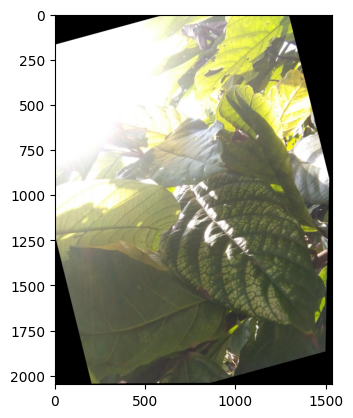

In [91]:
# Plot the rnd_no_detect_image
image_path = TEST_IMAGES_DIR / rnd_no_detect_image
image = np.array(Image.open(str(image_path)))
plt.imshow(image);

In [92]:
no_detection['Image_ID'].unique()

array(['ID_anegvH.jpeg', 'ID_bqjNRc.JPG', 'ID_Ev1UJ0.jpg', 'ID_ewBCM4.jpg', 'ID_GM6Ads.JPG', 'ID_HiEYk8.jpg', 'ID_iVdvqB.jpg', 'ID_ksM9yC.JPG', 'ID_lCVw1q.jpg', 'ID_nuUNo0.jpg', 'ID_PH0j4i.jpg', 'ID_QcU601.jpg', 'ID_QXeZ8d.jpeg', 'ID_R3h05n.jpg', 'ID_XjtU7g.jpg', 'ID_XzSqhK.JPG', 'ID_YpuhPQ.jpg', 'ID_yze4gA.jpg',
       'ID_zUj61k.jpg'], dtype=object)

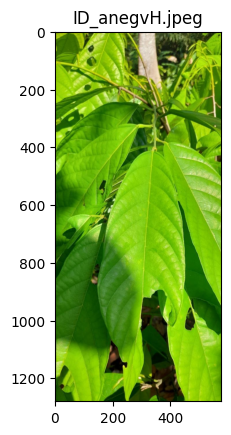

--------------------------------------



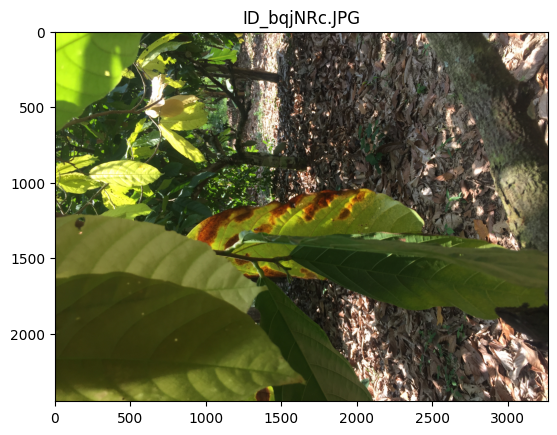

--------------------------------------



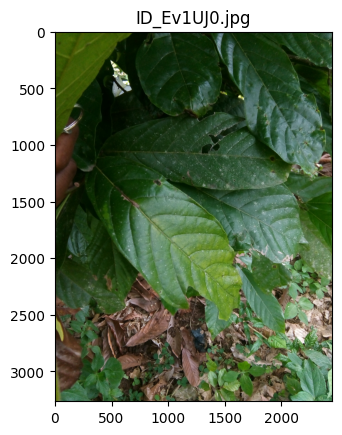

--------------------------------------



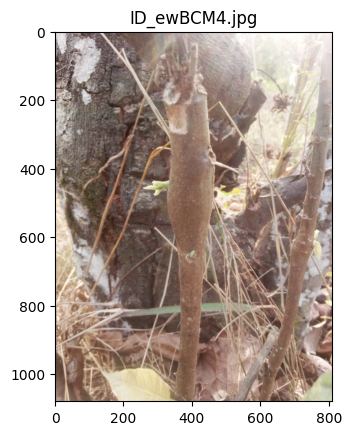

--------------------------------------



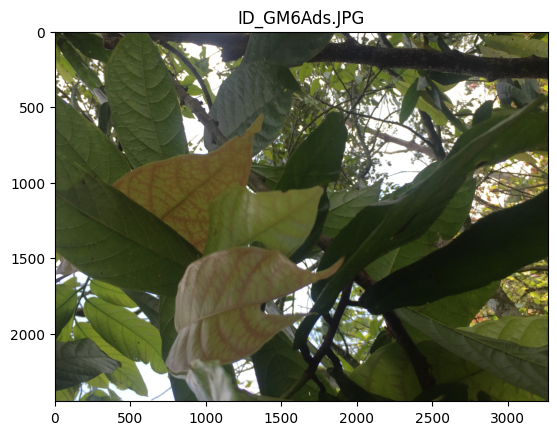

--------------------------------------



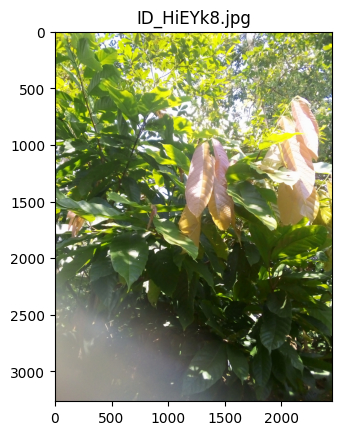

--------------------------------------



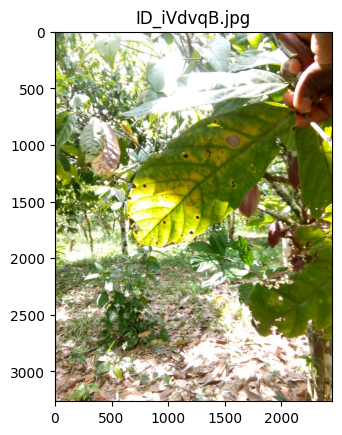

--------------------------------------



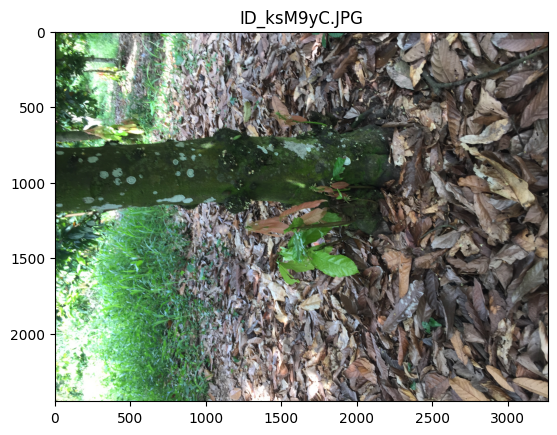

--------------------------------------



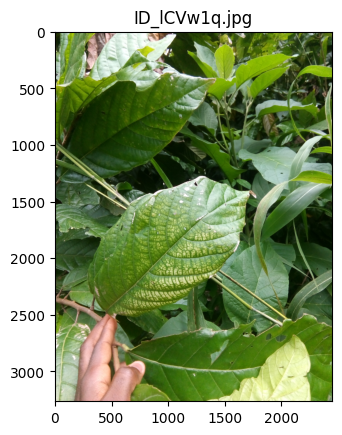

--------------------------------------



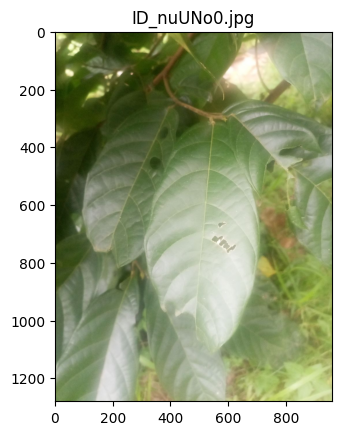

--------------------------------------



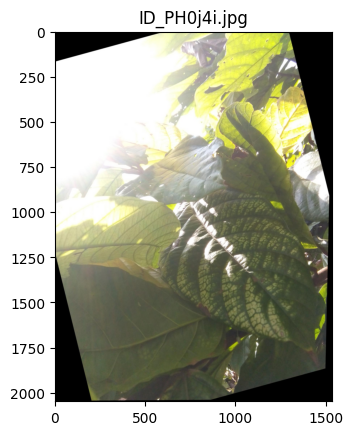

--------------------------------------



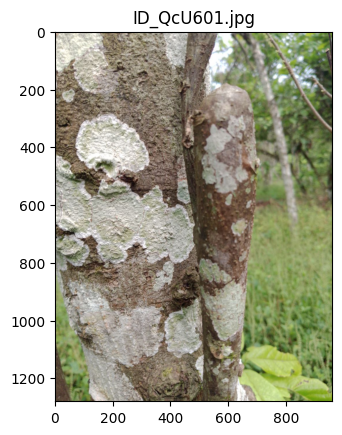

--------------------------------------



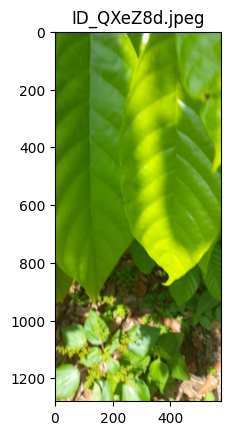

--------------------------------------



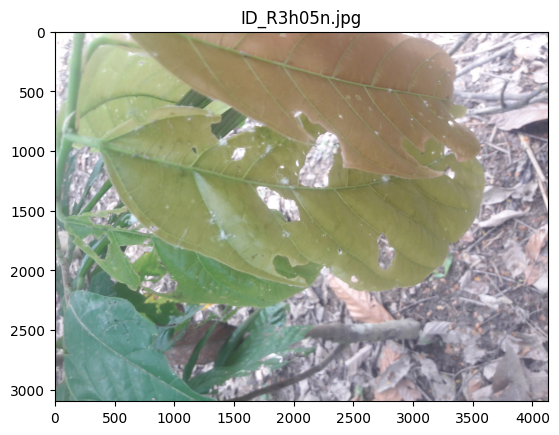

--------------------------------------



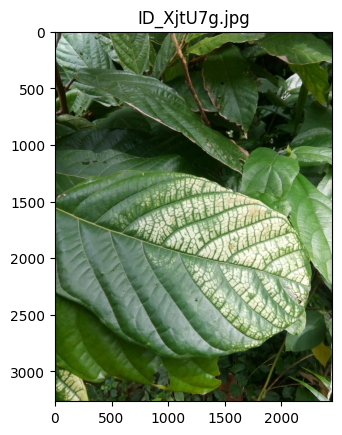

--------------------------------------



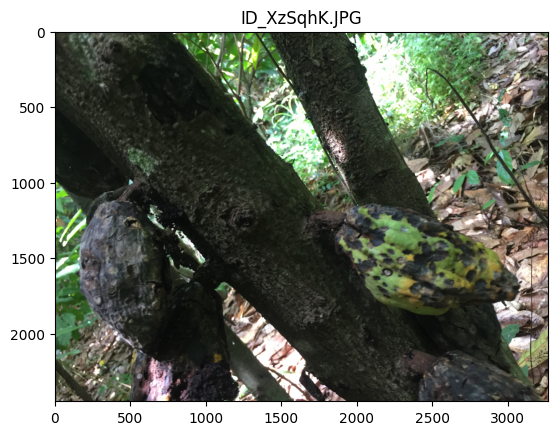

--------------------------------------



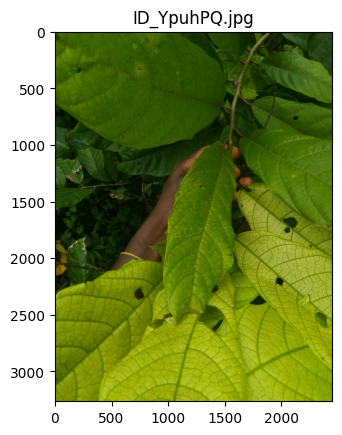

--------------------------------------



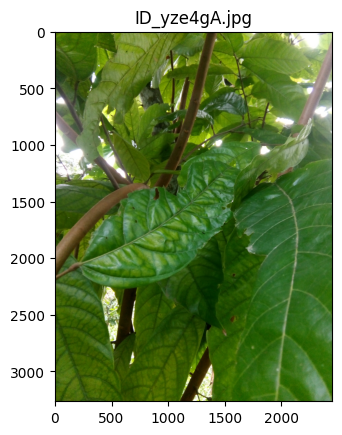

--------------------------------------



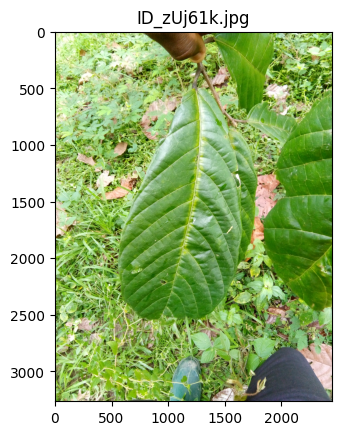

--------------------------------------



In [93]:
# Plot each of the image in no_detection dataframe
for image_name in no_detection['Image_ID'].unique():
    image_path = TEST_IMAGES_DIR / image_name
    plt.title(image_name)
    image = np.array(Image.open(str(image_path)))
    plt.imshow(image)
    plt.show()
    print('--------------------------------------\n')

In [104]:
import pandas as pd

# Load the file Yolo11n_50epo.csv
input_file = "Yolo11n_50epo.csv"
df = pd.read_csv(input_file)

# Limit the bounding box coordinates to 1024
bbox_cols = ['xmin', 'xmax', 'ymin', 'ymax']
for col in bbox_cols:
    df[col] = df[col].apply(lambda x: min(x, 2048))  # Set value to 1024 if it exceeds 1024

# Save the modified DataFrame to a new CSV file
output_file = "Yolo11n_50epo_limited_bboxes.csv"
df.to_csv(output_file, index=False)

print(f"New file saved: {output_file}")


New file saved: Yolo11n_50epo_limited_bboxes.csv


In [3]:
import pandas as pd

# Load prediction files
df1 = pd.read_csv("Yolo11n_50epo.csv")  # YOLOv11n
df2 = pd.read_csv("Yolo11m_70EPO_640.csv")  # YOLOv11m

print(f"YOLOv11n: {df1.shape[0]} rows")
print(f"YOLOv11m: {df2.shape[0]} rows")

# Merge only on Image_ID and class — ensure bounding boxes represent the same object
merged = pd.merge(df1, df2, on=["Image_ID", "class"], suffixes=('_n', '_m'))

# Confidence-weighted average of bounding boxes
def weighted_avg(col_n, col_m, conf_n, conf_m):
    return (col_n * conf_n + col_m * conf_m) / (conf_n + conf_m)

# Create merged DataFrame
averaged = pd.DataFrame({
    "Image_ID": merged["Image_ID"],
    "class": merged["class"],
    "confidence": (merged["confidence_n"] + merged["confidence_m"]) / 2,
    "xmin": weighted_avg(merged["xmin_n"], merged["xmin_m"], merged["confidence_n"], merged["confidence_m"]),
    "xmax": weighted_avg(merged["xmax_n"], merged["xmax_m"], merged["confidence_n"], merged["confidence_m"]),
    "ymin": weighted_avg(merged["ymin_n"], merged["ymin_m"], merged["confidence_n"], merged["confidence_m"]),
    "ymax": weighted_avg(merged["ymax_n"], merged["ymax_m"], merged["confidence_n"], merged["confidence_m"]),
})

# Identify unmatched predictions in df1
df1_keys = set(zip(df1.Image_ID, df1['class']))
merged_keys = set(zip(merged.Image_ID, merged['class']))
df1_unmatched = df1[[ (k not in merged_keys) for k in zip(df1.Image_ID, df1['class']) ]]

# Identify unmatched predictions in df2
df2_keys = set(zip(df2.Image_ID, df2['class']))
df2_unmatched = df2[[ (k not in merged_keys) for k in zip(df2.Image_ID, df2['class']) ]]

# Combine everything
final_df = pd.concat([averaged, df1_unmatched, df2_unmatched], ignore_index=True)

# Save to CSV
output_file = "Averaged_Yolo11n_Yolo11m_weighted.csv"
final_df.to_csv(output_file, index=False)

print(f"Merged file saved: {output_file}")
print(f"Final prediction count: {final_df.shape[0]}")


YOLOv11n: 3097 rows
YOLOv11m: 2812 rows
Merged file saved: Averaged_Yolo11n_Yolo11m_weighted.csv
Final prediction count: 7260


In [12]:
import pandas as pd

# Load the CSV
df = pd.read_csv("BIGDATA_n.csv")

# Step 1: Drop predictions with confidence < 1e-5
final_df = df[df['confidence'] >= 3e-4]

# Save output
final_df.to_csv("filter_BIG_DATA_E4.csv", index=False)
print(f"✅ Final size: {len(df)} rows")

print(f"✅ Final size: {len(final_df)} rows")


✅ Final size: 485870 rows
✅ Final size: 104567 rows


In [55]:
final_df

Image_ID        class  confidence         ymin         xmin  \
0       ID_a0srv9.jpg  anthracnose    0.773375   388.047729   849.443787   
1       ID_a0srv9.jpg  anthracnose    0.660204  1478.575928  1391.293457   
2       ID_a0srv9.jpg  anthracnose    0.044627  1187.299316     0.135095   
3       ID_a0srv9.jpg  anthracnose    0.018255     8.895366   919.110107   
4       ID_a0srv9.jpg      healthy    0.011599   527.411438  2819.027832   
...               ...          ...         ...          ...          ...   
324891  ID_zzaEcN.jpg        cssvd    0.000011  1726.893066   852.484802   
324892  ID_zzaEcN.jpg      healthy    0.000011    60.170856     0.000000   
324893  ID_zzaEcN.jpg      healthy    0.000011     0.000000  1137.473389   
324894  ID_zzaEcN.jpg        cssvd    0.000011  1201.328979     9.718828   
324895  ID_zzaEcN.jpg        cssvd    0.000011    88.611755   866.978088   

               ymax         xmax  
0       2154.792969  2505.600586  
1       2431.618896  3261.837891  
2       1952.099854   409.730194  
3        531.247070  2076.735596  
4        773.309265  3066.753418  
...             ...          ...  
324891  2048.000000  1064.443237  
324892   240.473038    18.056997  
324893   125.850594  1527.163696  
324894  1480.446899   198.131714  
324895   432.900452  1367.161743  

[324896 rows x 7 columns]

In [51]:
df

Image_ID        class  confidence         ymin         xmin  \
0       ID_a0srv9.jpg  anthracnose    0.773375   388.047729   849.443787   
1       ID_a0srv9.jpg  anthracnose    0.660204  1478.575928  1391.293457   
2       ID_a0srv9.jpg  anthracnose    0.044627  1187.299316     0.135095   
3       ID_a0srv9.jpg  anthracnose    0.018255     8.895366   919.110107   
4       ID_a0srv9.jpg      healthy    0.011599   527.411438  2819.027832   
...               ...          ...         ...          ...          ...   
437115  ID_zZzDQd.jpg  anthracnose    0.000014  1979.289917   896.310913   
437116  ID_zZzDQd.jpg  anthracnose    0.000014     0.000000  1030.372314   
437117  ID_zZzDQd.jpg  anthracnose    0.000014  1795.765747  1509.611694   
437118  ID_zZzDQd.jpg  anthracnose    0.000014    32.308525  1517.248047   
437119  ID_zZzDQd.jpg        cssvd    0.000014   244.243576  1148.542603   

               ymax         xmax  
0       2154.792969  2505.600586  
1       2431.618896  3261.837891  
2       1952.099854   409.730194  
3        531.247070  2076.735596  
4        773.309265  3066.753418  
...             ...          ...  
437115  2047.948120  1441.654907  
437116   285.577423  1373.466187  
437117  2048.000000  1536.000000  
437118   354.943359  1536.000000  
437119   518.100952  1533.630493  

[437120 rows x 7 columns]